# Introduction

This notebook presents **Many-to-Many** architecture based on **Bidirectional LSTM** cells. Neural network is used to learn **English to French** translation task on a small corpus of sequences.

<img src="assets/rnn_bidirectional.png"/>
<center>Figure from Bidirectional Recurrent Neural Networks (1997) by Mike Schuster and kuldip K. Paliwal</center>

**Dataset**

* [Udacity NLP Nanodegree](https://eu.udacity.com/course/natural-language-processing-nanodegree--nd892) - I found dataset as part of the course
* [Udacity NLP GitHub](https://github.com/udacity/aind2-nlp-capstone) - dataset link

**Resources**

* [Bidirectional Recurrent Neural Networks](https://ieeexplore.ieee.org/document/650093) (1997) by Mike Schuster and kuldip K. Paliwal

# Imports

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

Limit TensorFlow GPU memory usage

In [2]:
import tensorflow as tf
gpu_options = tf.GPUOptions(allow_growth=True)  # init TF ...
config=tf.ConfigProto(gpu_options=gpu_options)  # w/o taking ...
with tf.Session(config=config): pass            # all GPU memory

# English to French Dataset

Download dataset from the link in the introduction and point path below to folder with *small_vocab_en* and *small_vocab_fr*

In [3]:
dataset_location = '/home/marcin/Dropbox/Courses/Udacity/NLPND/aind2-nlp-capstone/data/'

*small_vocab_en* contains approx 137860 short sentences in English. *small_vocab_fr* contains corresponding sentences in french.

In [4]:
with open(os.path.join(dataset_location, 'small_vocab_en')) as f:
    # line below: 1) reads lines from file,
    #             2) strips /n char and converts to lowercase,
    #             3) adds special start/end words
    data_en_raw = list(map(lambda x: 'ST '+x.strip().lower()+' EN', f.readlines()))
print('len:', len(data_en_raw))
print('example sentences:')
data_en_raw[0:3]

len: 137860
example sentences:


['ST new jersey is sometimes quiet during autumn , and it is snowy in april . EN',
 'ST the united states is usually chilly during july , and it is usually freezing in november . EN',
 'ST california is usually quiet during march , and it is usually hot in june . EN']

In [5]:
with open(os.path.join(dataset_location, 'small_vocab_fr')) as f:
    # line below: 1) reads lines from file,
    #             2) strips /n char and converts to lowercase,
    #             3) adds special start/end words
    data_fr_raw = list(map(lambda x: 'ST '+x.strip().lower()+' EN', f.readlines()))
print('len:', len(data_fr_raw))
print('example sentences:')
data_fr_raw[0:3]

len: 137860
example sentences:


["ST new jersey est parfois calme pendant l' automne , et il est neigeux en avril . EN",
 'ST les états-unis est généralement froid en juillet , et il gèle habituellement en novembre . EN',
 'ST california est généralement calme en mars , et il est généralement chaud en juin . EN']

Use Keras tokenizer to convert text sentences to tokens. Each word gets it's own unique integer token. Special words ST/EN also get their tokens.

In [6]:
tok_en = tf.keras.preprocessing.text.Tokenizer(lower=False)
tok_en.fit_on_texts(data_en_raw)
data_en_tok = tok_en.texts_to_sequences(data_en_raw)

In [7]:
print('example tokens for English:')
print('is:', tok_en.word_index['is'], '   ',
      'ST:', tok_en.word_index['ST'], '   ',
      'EN:', tok_en.word_index['EN'], '   ',
      'in:', tok_en.word_index['in'], '   ',
      'it:', tok_en.word_index['it'])
print('example sentences after tokenization:')
data_en_tok[0:3]

example tokens for English:
is: 1     ST: 2     EN: 3     in: 4     it: 5
example sentences after tokenization:


[[2, 19, 25, 1, 10, 69, 6, 41, 9, 5, 1, 57, 4, 46, 3],
 [2, 7, 22, 23, 1, 11, 64, 6, 45, 9, 5, 1, 11, 53, 4, 47, 3],
 [2, 24, 1, 11, 69, 6, 40, 9, 5, 1, 11, 70, 4, 36, 3]]

In [8]:
tok_fr = tf.keras.preprocessing.text.Tokenizer(lower=False)
tok_fr.fit_on_texts(data_fr_raw)
data_fr_tok = tok_fr.texts_to_sequences(data_fr_raw)

In [9]:
print('example tokens for French:')
print('est:', tok_fr.word_index['est'], '   ',
      'ST:', tok_fr.word_index['ST'], '   ',
      'EN:', tok_fr.word_index['EN'], '   ',
      'en:', tok_fr.word_index['en'], '   ',
      'il:', tok_fr.word_index['il'])
print('example sentences after tokenization:')
data_fr_tok[0:3]

example tokens for French:
est: 1     ST: 2     EN: 3     en: 4     il: 5
example sentences after tokenization:


[[2, 37, 36, 1, 10, 69, 39, 13, 26, 8, 5, 1, 114, 4, 52, 3],
 [2, 6, 34, 33, 1, 14, 21, 4, 51, 8, 5, 97, 71, 4, 53, 3],
 [2, 103, 1, 14, 69, 4, 47, 8, 5, 1, 14, 23, 4, 43, 3]]

Calculate maximum sentence lengths

In [10]:
max_len_en = len(max(data_en_tok, key=len))
max_len_fr = len(max(data_fr_tok, key=len))
max_len_both = max(max_len_en, max_len_fr)
print('Max length English sentence (tokens):   ', max_len_en)
print('Max length French sentence (tokens):    ', max_len_fr)
print('Max length in either English or French:', max_len_both, 'tokens (including EN/ST)')

Max length English sentence (tokens):    17
Max length French sentence (tokens):     23
Max length in either English or French: 23 tokens (including EN/ST)


Pad both corpuses to longest sentence - input and output lenghts need to match

In [11]:
data_en = tf.keras.preprocessing.sequence.pad_sequences(data_en_tok, maxlen=max_len_both, padding='post')
data_fr = tf.keras.preprocessing.sequence.pad_sequences(data_fr_tok, maxlen=max_len_both, padding='post')

Print some statistics

In [12]:
n_en_seq = data_en.shape[1]
n_fr_seq = data_fr.shape[1]
n_en_vocab = len(tok_en.word_index)
n_fr_vocab = len(tok_fr.word_index)
max_seq_len = max(n_en_seq, n_fr_seq)
print('English sequence length (tokens):   ', n_en_seq)
print('French sequence length (tokens):    ', n_fr_seq)
print('Num tokens in English vocabulary:   ', n_en_vocab)
print('Num tokens in English vocabulary:   ', n_fr_vocab)

English sequence length (tokens):    23
French sequence length (tokens):     23
Num tokens in English vocabulary:    201
Num tokens in English vocabulary:    346


In [13]:
print('English train data')
print('shape:', data_en.shape)
print(data_en[4:7])

English train data
shape: (137860, 23)
[[ 2 31 14 18 15  1  7 84  8 32 14 18  1  7 85  3  0  0  0  0  0  0  0]
 [ 2 33 13 15  1  7 86  8 32 13  1  7 84  3  0  0  0  0  0  0  0  0  0]
 [ 2 20  1 68  6 49  8  5  1 11 64  4 45  3  0  0  0  0  0  0  0  0  0]]


In [14]:
print('French train targets data')
print('shape:', data_fr.shape)
print(data_fr[4:7])

French train targets data
shape: (137860, 23)
[[ 2 42 15 16 18  1 12 84  7 41 15 16  1  9 85  3  0  0  0  0  0  0  0]
 [ 2 22 18 19  1 86  7 41 19  1 12 84  3  0  0  0  0  0  0  0  0  0  0]
 [ 2 31  1 60  4 54  7  5  1 14 21  4 51  3  0  0  0  0  0  0  0  0  0]]


# Bidirectional LSTM

In [15]:
from tensorflow.keras.layers import Input, Embedding, Bidirectional, GRU
from tensorflow.keras.layers import TimeDistributed, Dense, Activation

Create Keras model

In [17]:
X_input = Input(shape=(n_en_seq,))                                        # (?, 23)
X_embed = Embedding(input_dim=n_en_vocab, output_dim=50)(X_input)         # (?, 23, 50)
X_bidir = Bidirectional( GRU(units=64, return_sequences=True) )(X_embed)  # (?, 23, 128)
X_td = TimeDistributed(Dense(units=n_fr_vocab))(X_bidir)                  # (?, 23, 346)
X_act = Activation('softmax')(X_td)                                       # (?, 23, 346)

model = tf.keras.Model(inputs=X_input, outputs=X_act)
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(lr=0.001),
              metrics=[tf.keras.metrics.sparse_categorical_accuracy])    
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 23)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 23, 50)            10050     
_________________________________________________________________
bidirectional_1 (Bidirection (None, 23, 128)           44160     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 23, 346)           44634     
_________________________________________________________________
activation_1 (Activation)    (None, 23, 346)           0         
Total params: 98,844
Trainable params: 98,844
Non-trainable params: 0
_________________________________________________________________


Optional: plot nice diagram and save to file. This requires `graphviz` and `pydot` to be installed.

In [18]:
# from tensorflow.keras.utils import plot_model
# plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

The result should be as follows:

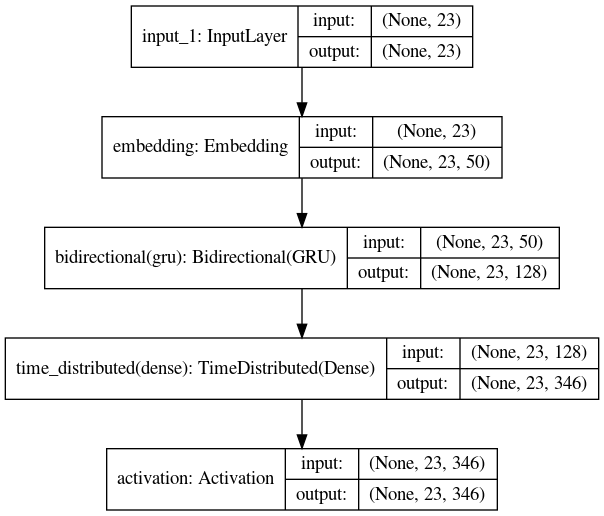

Train model

In [21]:
hist = model.fit(x=data_en, y=np.expand_dims(data_fr, axis=-1),
                 batch_size=1024, epochs=10, validation_split=0.2)

Train on 110288 samples, validate on 27572 samples
Epoch 1/10
110288/110288 [==============================] - 9s 78us/sample - loss: 3.5285 - sparse_categorical_accuracy: 0.4073 - val_loss: nan - val_sparse_categorical_accuracy: 0.4783
Epoch 2/10
110288/110288 [==============================] - 8s 69us/sample - loss: 2.2910 - sparse_categorical_accuracy: 0.5019 - val_loss: nan - val_sparse_categorical_accuracy: 0.5513
Epoch 3/10
110288/110288 [==============================] - 8s 69us/sample - loss: 1.5731 - sparse_categorical_accuracy: 0.6165 - val_loss: nan - val_sparse_categorical_accuracy: 0.6587
Epoch 4/10
110288/110288 [==============================] - 8s 69us/sample - loss: 1.2017 - sparse_categorical_accuracy: 0.6891 - val_loss: nan - val_sparse_categorical_accuracy: 0.7180
Epoch 5/10
110288/110288 [==============================] - 8s 69us/sample - loss: 0.9734 - sparse_categorical_accuracy: 0.7407 - val_loss: nan - val_sparse_categorical_accuracy: 0.7591
Epoch 6/10
110288/1

**Test Model**

Helper function to convert tokenized sentence back to words

In [22]:
def sequence_to_french(seq):
    words = [tok_fr.index_word[x] for x in seq if x in tok_fr.index_word]
    return ' '.join(words)

In [23]:
index = 234
english_sentence = data_en_raw[index]
french_sentence = data_fr_raw[index]

prediction_prob = model.predict(data_en[index:index+1])
prediction_prob = prediction_prob.squeeze()
prediction_tok = prediction_prob.argmax(axis=-1)
predicted_sentence = sequence_to_french(prediction_tok)

print('english:            ', english_sentence)
print('french (original):  ', french_sentence)
print('french (predicted): ', predicted_sentence)

english:             ST we dislike oranges , grapefruit , and bananas . EN
french (original):   ST nous détestons les oranges , le pamplemousse et les bananes . EN
french (predicted):  ST nous détestons les oranges le pamplemousse et les les EN
